In [1]:
import glob
import os
import json

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import cPickle as pkl


from pipeline.python.classifications import experiment_classes as util


import scipy.stats as spstats

from pipeline.python.utils import label_figure, natural_keys
from pipeline.python.classifications import bootstrap_osi as osi
from pipeline.python.classifications import get_dataset_stats as gd

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in la

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/test_responsivity.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applicat

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/target_visual_field.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application

# Get session info

In [2]:
options = ['-t', 'traces001']

optsE = gd.extract_options(options)


rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type

print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [3]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

In [4]:
sdata.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,4
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,2,4
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4


In [5]:
dsets = sdata[sdata['experiment']=='gratings']

In [6]:
traceid = 'traces001'

response_type = 'dff'
responsive_test = 'nstds' #'nstds' #'ROC'
responsive_thr = 10 #0.05
n_bootstrap_iters=1000
n_resamples = 20

In [7]:
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test, responsive_thr=responsive_thr,
                            n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples)
print fit_desc

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [8]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [9]:
destdir = os.path.join(aggregate_dir, 'orientation-tuning', '%s-%s' % (traceid, fit_desc))
print(destdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [10]:
aggstats_fpath = glob.glob(os.path.join(destdir, '*.pkl'))[0]
with open(aggstats_fpath, 'rb') as f:
    stats = pkl.load(f)
#stats

In [11]:
[(skey, len(vals)) for skey, vals in stats.items() if not isinstance(vals, int)]

[('JC080_20190603_FOV1_zoom2p0x', 16),
 ('JC090_20190605_FOV1_zoom2p0x', 2),
 ('JC091_20190602_FOV1_zoom2p0x', 6),
 ('JC091_20190627_FOV1_zoom2p0x', 9),
 ('JC083_20190517_FOV1_zoom2p0x', 4),
 ('JC097_20190617_FOV1_zoom2p0x', 9),
 ('JC097_20190616_FOV1_zoom2p0x', 29),
 ('JC083_20190511_FOV1_zoom2p0x', 36),
 ('JC083_20190512_FOV1_zoom2p0x', 25),
 ('JC084_20190525_FOV1_zoom2p0x', 15),
 ('JC091_20190606_FOV1_zoom2p0x', 2),
 ('JC099_20190612_FOV1_zoom2p0x', 4),
 ('JC085_20190622_FOV1_zoom2p0x', 22),
 ('JC091_20190607_FOV1_zoom2p0x', 4),
 ('JC097_20190613_FOV1_zoom2p0x', 10),
 ('JC084_20190522_FOV1_zoom2p0x', 28),
 ('JC091_20190614_FOV1_zoom2p0x', 6),
 ('JC078_20190513_FOV1_zoom2p0x', 34)]

In [11]:
[(skey, len(vals)) for skey, vals in stats.items() if not isinstance(vals, int)]

[('JC080_20190603_FOV1_zoom2p0x', 16),
 ('JC090_20190605_FOV1_zoom2p0x', 2),
 ('JC091_20190602_FOV1_zoom2p0x', 6),
 ('JC091_20190627_FOV1_zoom2p0x', 9),
 ('JC083_20190517_FOV1_zoom2p0x', 4),
 ('JC097_20190617_FOV1_zoom2p0x', 9),
 ('JC097_20190616_FOV1_zoom2p0x', 29),
 ('JC083_20190511_FOV1_zoom2p0x', 36),
 ('JC083_20190512_FOV1_zoom2p0x', 25),
 ('JC084_20190525_FOV1_zoom2p0x', 15),
 ('JC091_20190606_FOV1_zoom2p0x', 2),
 ('JC099_20190612_FOV1_zoom2p0x', 4),
 ('JC085_20190622_FOV1_zoom2p0x', 22),
 ('JC091_20190607_FOV1_zoom2p0x', 4),
 ('JC097_20190613_FOV1_zoom2p0x', 10),
 ('JC084_20190522_FOV1_zoom2p0x', 28),
 ('JC091_20190614_FOV1_zoom2p0x', 6),
 ('JC078_20190513_FOV1_zoom2p0x', 34)]

In [12]:
[(skey, len(vals)) for skey, vals in stats.items()]

TypeError: object of type 'int' has no len()

# Aggregate all tuning data

In [47]:
# animalid = 'JC084'
# session ='20190522'

In [12]:
rootdir = '/n/coxfs01/2p-data'
# fov_type = 'zoom2p0x'


In [13]:
def get_average_tuning_over_iters(fitdf):
    means = {}
    roi = int(fitdf['cell'].unique()[0])
    for param in fitdf.columns:
        if 'theta' in param:
            meanval = np.rad2deg(spstats.circmean(np.deg2rad(fitdf[param].values % 360.)))
        else:
            meanval = fitdf[param].values.mean()
        
        means[param] = meanval
    
    return pd.DataFrame(means, index=[roi])

In [18]:
animalid = 'JC097'
session = '20190616'
fov = 'FOV1_zoom2p0x'

In [19]:
gof_thr=0.6
bootresults, fitparams = osi.load_tuning_results(animalid, session, fov, 'combined_gratings_static', \
                                                 traceid, fit_desc)
rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
print("%i cells with good fits." % rmetrics.shape[0])

Loading existing fits.
141 cells fit at least 1 tuning curve.
43 cells with good fits.


In [20]:
rmetrics

,asi,cell,dsi,gof,r2,r2comb,response_null,response_offset,response_pref,sigma,theta_pref
24,0.191290,24.0,0.074363,0.632734,0.789636,0.799521,0.230234,-0.126266,0.247837,62.220619,61.768414
38,0.543377,38.0,0.147366,0.819690,0.906602,0.937055,0.062144,0.000503,0.085060,29.007815,309.795455
48,0.642770,48.0,0.115510,0.691190,0.855431,0.784770,0.113970,0.005232,0.139783,24.277308,195.725677
64,0.187926,64.0,0.042578,0.651027,0.804258,0.873535,0.068259,0.050924,0.082002,24.412606,265.009839
79,0.362348,79.0,0.044172,0.787851,0.898248,0.881880,0.055260,-0.011410,0.058840,43.169932,244.761229
90,0.531391,90.0,0.196283,0.953962,0.973457,0.982620,0.098252,0.018604,0.138446,23.910592,358.546125
91,0.245096,91.0,0.072450,0.817696,0.907060,0.922480,0.047454,0.023869,0.064788,28.716606,264.226412
93,0.288664,93.0,0.073894,0.688906,0.899352,0.681296,0.295702,-0.051883,0.346612,44.187523,216.879742
96,0.183583,96.0,0.154459,0.680536,0.889608,0.689809,0.059557,0.005465,0.095587,43.185323,48.003872
121,0.215264,121.0,0.070662,0.614351,0.868507,0.604903,0.072528,-0.003651,0.089336,42.478393,240.246208


In [21]:
rmetrics['cell'].unique()

array([ 24.,  38.,  48.,  64.,  79.,  90.,  91.,  93.,  96., 121., 123.,
       134., 137., 142., 146., 147., 148., 165., 169., 172., 176., 178.,
       187., 193., 207., 211., 238., 243., 250., 254., 256., 268., 285.,
       319., 355., 384., 388., 389., 390., 411., 418., 423., 428.])

In [20]:
pd.concat([rmetrics_by_cfg.groupby(['cell']).get_group(roi).sort_values(by=['asi','dsi'],ascending=False).iloc[0]\
           for roi in rmetrics['cell'].unique()], axis=1).T


,asi,cell,dsi,gof,r2,r2comb,response_null,response_offset,response_pref,sigma,theta_pref
sf-0.50-sz-20-sp-20,0.240949,5.0,0.243878,0.611685,0.800848,0.803206,0.047854,0.041030,0.146590,34.663851,340.767595
sf-0.10-sz-20-sp-10,0.247218,9.0,0.050520,0.685462,0.844288,0.839958,0.129756,0.059406,0.154795,27.576595,89.324873
sf-0.10-sz-200-sp-10,0.232947,11.0,0.069633,0.520092,0.787989,0.588402,0.276504,-0.021767,0.311419,43.133129,237.313935
sf-0.10-sz-200-sp-10,0.148719,17.0,0.137196,0.672269,0.816426,0.890061,0.054599,0.115931,0.201693,22.903431,87.051640
sf-0.10-sz-20-sp-20,0.160598,25.0,0.133746,0.648776,0.887434,0.617932,0.298300,-0.133080,0.407464,56.010279,119.554010
sf-0.10-sz-20-sp-20,0.527228,30.0,0.319626,0.942799,0.967811,0.976826,0.147027,0.030564,0.407769,22.502228,269.136577
sf-0.10-sz-20-sp-10,0.180459,33.0,0.075469,0.661337,0.849619,0.772864,0.082828,0.069959,0.160391,30.143800,217.978514
sf-0.10-sz-20-sp-20,0.336643,45.0,0.097710,0.790134,0.900347,0.910741,0.161932,0.022588,0.217593,32.835111,267.387873
sf-0.10-sz-200-sp-20,0.277141,51.0,0.102616,0.548960,0.767671,0.734550,0.140020,0.021376,0.205014,34.636467,267.154943
sf-0.50-sz-200-sp-20,0.322241,54.0,0.139111,0.823429,0.909555,0.931002,0.425486,0.123230,0.599162,35.210768,30.054310


In [22]:
print gof_thr

0.6


In [23]:
gdata = []
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    
    bootresults, fitparams = osi.load_tuning_results(animalid, session, fov, 'combined_gratings_static', \
                                                     traceid, fit_desc)
    rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
    if rmetrics is None:
        continue
    print("%i cells with good fits." % rmetrics.shape[0])

    meandf = pd.concat([rmetrics_by_cfg.groupby(['cell']).get_group(roi).sort_values(by=['asi','dsi'],ascending=False).iloc[0]\
           for roi in rmetrics['cell'].unique()], axis=1).T

    ncells = meandf.shape[0]
    meandf['visual_area'] = [visual_area for _ in range(ncells)]
    meandf['animalid'] = [animalid for _ in range(ncells)]
    meandf['session'] = [session for _ in range(ncells)]
    meandf['fov'] = [fov for _ in range(ncells)]
    
    gdata.append(meandf)
        

Loading existing fits.
25 cells fit at least 1 tuning curve.
5 cells with good fits.
Loading existing fits.
69 cells fit at least 1 tuning curve.
12 cells with good fits.
Loading existing fits.
19 cells fit at least 1 tuning curve.
4 cells with good fits.
Loading existing fits.
53 cells fit at least 1 tuning curve.
7 cells with good fits.
Loading existing fits.
49 cells fit at least 1 tuning curve.
8 cells with good fits.
Loading existing fits.
12 cells fit at least 1 tuning curve.
1 cells with good fits.
Loading existing fits.
34 cells fit at least 1 tuning curve.
5 cells with good fits.
Loading existing fits.
5 cells fit at least 1 tuning curve.
Loading existing fits.
165 cells fit at least 1 tuning curve.
39 cells with good fits.
Loading existing fits.
78 cells fit at least 1 tuning curve.
20 cells with good fits.
Loading existing fits.
169 cells fit at least 1 tuning curve.
27 cells with good fits.
Loading existing fits.
15 cells fit at least 1 tuning curve.
5 cells with good fits.

In [24]:
gdata = pd.concat(gdata, axis=0)

In [25]:
gdata.shape

(333, 15)

# Visualize

In [26]:
%matplotlib notebook

In [27]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [28]:
def compare_tuning_metric(df, metric='ASI', cdf=False, ax=None, area_colors=None, show_legend=True, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
       

    for visual_area, tmpd in df.groupby(['visual_area']):
        nrats = len(tmpd['animalid'].unique())
        ncells_total = tmpd.shape[0]
        values = tmpd[metric].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i rats, %i cells)' % (visual_area, nrats, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

In [29]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [30]:
fit_desc

'fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

# Set output dir for aggregate figures

In [31]:
data_identifier = '|'.join(['gratings', fov_type, traceid, fit_desc, 'all-configs'])
data_identifier

'gratings|zoom2p0x|traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20|all-configs'

In [32]:
destdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

In [33]:
gdata[gdata['gof'] >= gof_thr].shape

(333, 15)

<IPython.core.display.Javascript object>


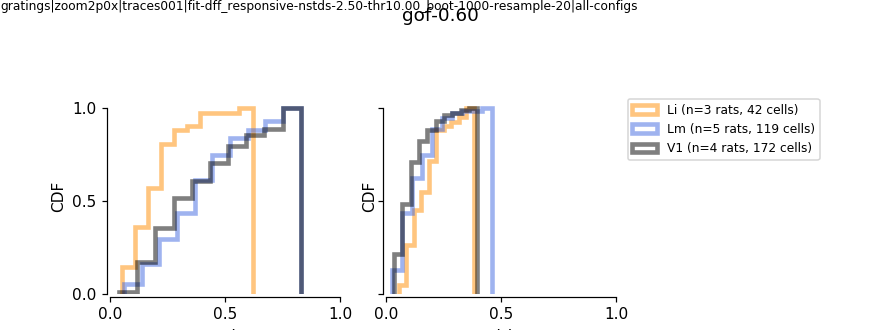

asi-dsi_all-configs-best_gof-0.60_cdf


In [34]:
#gof = 0.66
cdf = True
alpha = 0.5
filter_gof = True
if filter_gof:
    roi_str = 'gof-%.2f' % gof_thr
    rdata = gdata[gdata['gof'] >= gof_thr]
else:
    roi_str = 'all-cells'
    rdata = gdata.copy()

fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,3))
fig.patch.set_alpha(1)

ax = axes[0]
compare_tuning_metric(rdata, metric='asi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=alpha)
ax = axes[1]
compare_tuning_metric(rdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, alpha=alpha)

pl.subplots_adjust(wspace=0.2, right=0.7, top=0.7)
fig.suptitle(roi_str)
for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    sns.despine(ax=ax, trim=True, offset=2)
    
    
label_figure(fig, data_identifier)
figname = 'asi-dsi_all-configs-best_%s_%s' % (roi_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

# Look at other properties

In [35]:
import matplotlib.patches as mpatches


In [36]:
destdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

<IPython.core.display.Javascript object>


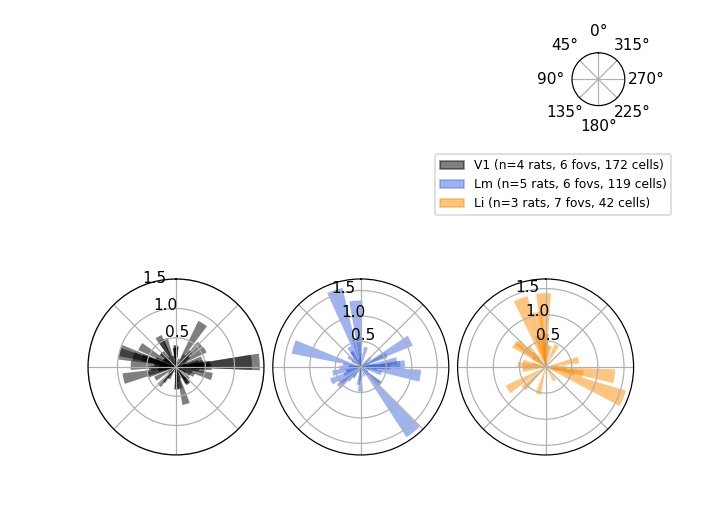

preferrd-thetas_all-configs-best_gof-0.60


In [37]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g.copy()
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad( np.arange(0, 360, 45) )
    widths = np.deg2rad( tmpg['theta_pref'].values )

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area])
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.5)
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    #ax.set_yticks(np.linspace(0, 1, 5))
    #ax.set_yticklabels(['']) #, '', 1])
    #ax.set_ylabel('dff')
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

figname = 'preferrd-thetas_all-configs-best_%s' % (roi_str)
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

<IPython.core.display.Javascript object>


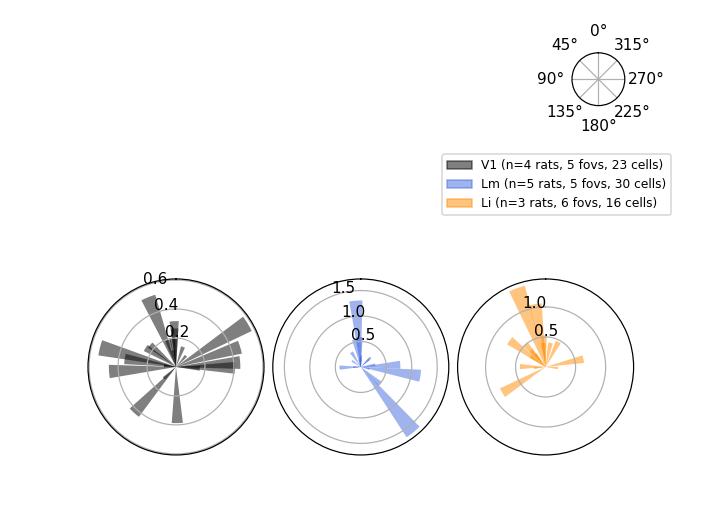

DS-preferrd-thetas_all-configs-best_gof-0.60


In [38]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g[g['dsi']>=0.2]
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad( np.arange(0, 360, 45) )
    widths = np.deg2rad( tmpg['theta_pref'].values )

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area])
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.5)
    ax.set_theta_zero_location("N")
    ax.set_xticks([])
    #ax.set_yticks(np.linspace(0, 1, 5))
    #ax.set_yticklabels(['']) #, '', 1])
    #ax.set_ylabel('dff')
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

figname = 'DS-preferrd-thetas_all-configs-best_%s' % (roi_str)
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

In [69]:
widths.max()

5.1628055060276825

<IPython.core.display.Javascript object>


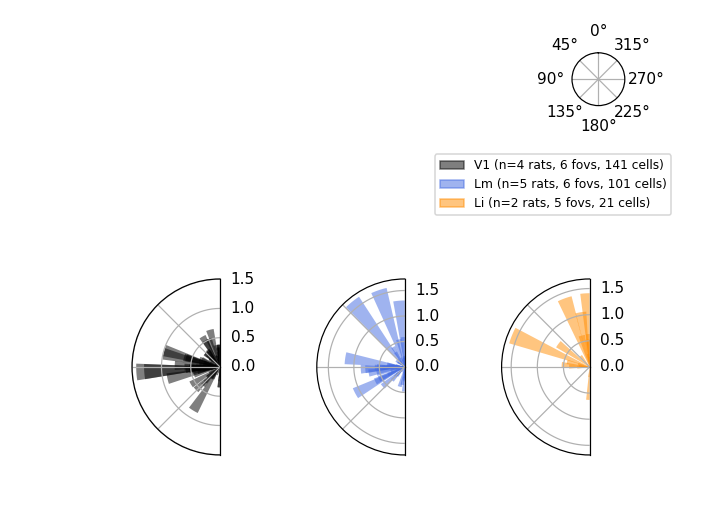

AS-preferrd-thetas_all-configs-best_gof-0.60


In [39]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g[g['asi']>=0.2]
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad(np.arange(0, 180+45, 45))
    widths = np.deg2rad(tmpg['theta_pref'] % 180.)

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area])
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.5)
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    ax.set_xlim([thetas[0], thetas[-1]])
    #ax.set_yticks(np.linspace(0, 1, 5))
    #ax.set_yticklabels(['']) #, '', 1])
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

figname = 'AS-preferrd-thetas_all-configs-best_%s' % (roi_str)
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

In [53]:
thetas

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165])

In [59]:
ax.get_xticks()

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714])